In [2]:
import os

In [3]:
%pwd

'c:\\Users\\aakas\\Documents\\Projects\\Thyroid-disease-detection\\research'

In [4]:
os.chdir("../")

In [5]:
%pwd

'c:\\Users\\aakas\\Documents\\Projects\\Thyroid-disease-detection'

In [53]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class ClusteringConfig:
    clustered_dir: Path
    cluster_model_dir: Path
    plot_dir: Path
    cluster_plot: str
    clustering_file: str
    cluster_model: str


In [6]:
from thyroid.constants import *
from thyroid.utils.common import read_yaml, create_directories

In [54]:
class ConfigurationManager:
    def __init__(self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_data_clustering_config(self) -> ClusteringConfig:
        config = self.config.data_transformation
        params = self.params.transformations

        create_directories([config.clustered_dir, config.cluster_model_dir, config.plot_dir])

        data_clustering_config = ClusteringConfig(
            clustered_dir=config.clustered_dir,
            cluster_model_dir=config.cluster_model_dir,
            plot_dir=config.plot_dir,
            cluster_plot=params.cluster_plot,
            clustering_file=params.clustering_file,
            cluster_model=params.cluster_model
        
        )

        return data_clustering_config

In [32]:
import os
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import typing as typing
from thyroid.logging import logger
from thyroid.utils.exception import customException
import pandas as pd

In [59]:
class DataClustering:
    def __init__(self, data, config: ClusteringConfig):
        self.config = config
        self.data = data
        self.Y = self.data['class']
        self.X = self.data.drop(columns=['class'])
        
        
    def plot_knee(self):
        """_summary_
        
        Input: dataframe
        
        Returns:
            _type_: kmeans plot
        """
        # scaler = StandardScaler()
        # self.X_scaled = scaler.fit_transform(self.X)
        wcss=[]
        for i in range (1,11):
            kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
            kmeans.fit(self.X) # fitting the data to the KMeans Algorithm
            wcss.append(kmeans.inertia_)
        plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        #plt.show()
        plt.savefig(os.path.join(self.config.plot_dir, self.config.cluster_plot)) # saving the elbow plot locally
        # finding the value of the optimum cluster programmatically
        kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
        logger.info('The optimum number of clusters is: '+str(kn.knee)+' . Exited the elbow_plot method of the KMeansClustering class')
        return kn.knee

    def create_clusters(self, optimal_k):
        kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
        
        self.X['cluster']=kmeans.fit_predict(self.X) #  divide data into clusters

        with open(os.path.join(self.config.cluster_model_dir, self.config.cluster_model), 'wb') as file:
            pickle.dump(kmeans, file) # saving the KMeans model to directory                                                                  
        logger.info('succesfully created ' +str(optimal_k)+ 'clusters. Exited the create_clusters method of the KMeansClustering class')

        # save the data
        self.X['class'] = self.Y
        self.X.to_csv(os.path.join(self.config.clustered_dir, self.config.clustering_file), index=False)
        logger.info(f"file saved as {self.config.clustering_file}")


In [60]:
import sys
import shutil

[ 2023-11-14 18:22:43,376 ] 30 thyroidDiseaselogger - INFO - yaml file: config\config.yaml loaded successfully
[ 2023-11-14 18:22:43,386 ] 30 thyroidDiseaselogger - INFO - yaml file: params.yaml loaded successfully
[ 2023-11-14 18:22:43,390 ] 49 thyroidDiseaselogger - INFO - created directory at: artifacts
[ 2023-11-14 18:22:43,393 ] 49 thyroidDiseaselogger - INFO - created directory at: artifacts/data_transformation/clustered_data
[ 2023-11-14 18:22:43,396 ] 49 thyroidDiseaselogger - INFO - created directory at: artifacts/models/cluster_model
[ 2023-11-14 18:22:43,400 ] 49 thyroidDiseaselogger - INFO - created directory at: artifacts/plots


c:\Users\aakas\Documents\Projects\Thyroid-disease-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aakas\Documents\Projects\Thyroid-disease-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aakas\Documents\Projects\Thyroid-disease-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aakas\Documents\Projects\Thyroid-disease-detec

[ 2023-11-14 18:22:57,315 ] 32 thyroidDiseaselogger - INFO - The optimum number of clusters is: 3 . Exited the elbow_plot method of the KMeansClustering class


c:\Users\aakas\Documents\Projects\Thyroid-disease-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[ 2023-11-14 18:22:57,829 ] 42 thyroidDiseaselogger - INFO - succesfully created 3clusters. Exited the create_clusters method of the KMeansClustering class
[ 2023-11-14 18:22:58,926 ] 47 thyroidDiseaselogger - INFO - file saved as clustering-data.csv


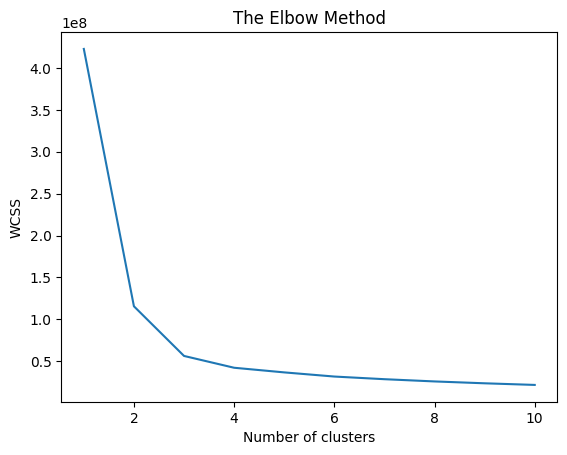

In [61]:
try:
    config = ConfigurationManager()
    data_clustering_config = config.get_data_clustering_config()
    df = pd.read_csv('./artifacts/data_transformation/transformed_data/transformed-data.csv')
    data_clustering = DataClustering(df,config=data_clustering_config)
    optimal_clusters = data_clustering.plot_knee()
    data_clustering.create_clusters(optimal_clusters)


    

except Exception as e:
    raise customException(e,sys) 

In [6]:
import pandas as pd
df = pd.read_csv('./artifacts/data_transformation/clustered_data/clustering-data.csv')

In [7]:
df.shape

(49644, 23)

In [8]:
df['cluster'].value_counts()

cluster
1    23748
2    18561
0     7335
Name: count, dtype: int64

In [9]:
df['class'].value_counts()

class
2    16548
0    16548
1    16548
Name: count, dtype: int64

In [66]:
df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH', 'T3', 'TT4', 'T4U',
       'FTI', 'cluster', 'class'],
      dtype='object')

In [27]:
# Find categorical columns
categorical_columns = data.select_dtypes(include=['object'])

# Print unique values for each categorical column
for column in categorical_columns:
    unique_values = data[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

In [30]:
data['class'].unique()

array([2, 0, 1])

In [18]:
data.isnull().sum().sort_values(ascending=False)

age                          0
goitre                       0
class                        0
FTI                          0
T4U                          0
TT4                          0
T3                           0
TSH                          0
psych                        0
hypopituitary                0
tumor                        0
lithium                      0
sex                          0
query_hyperthyroid           0
query_hypothyroid            0
I131_treatment               0
thyroid_surgery              0
pregnant                     0
sick                         0
on_antithyroid_medication    0
query_on_thyroxine           0
on_thyroxine                 0
Class                        0
dtype: int64

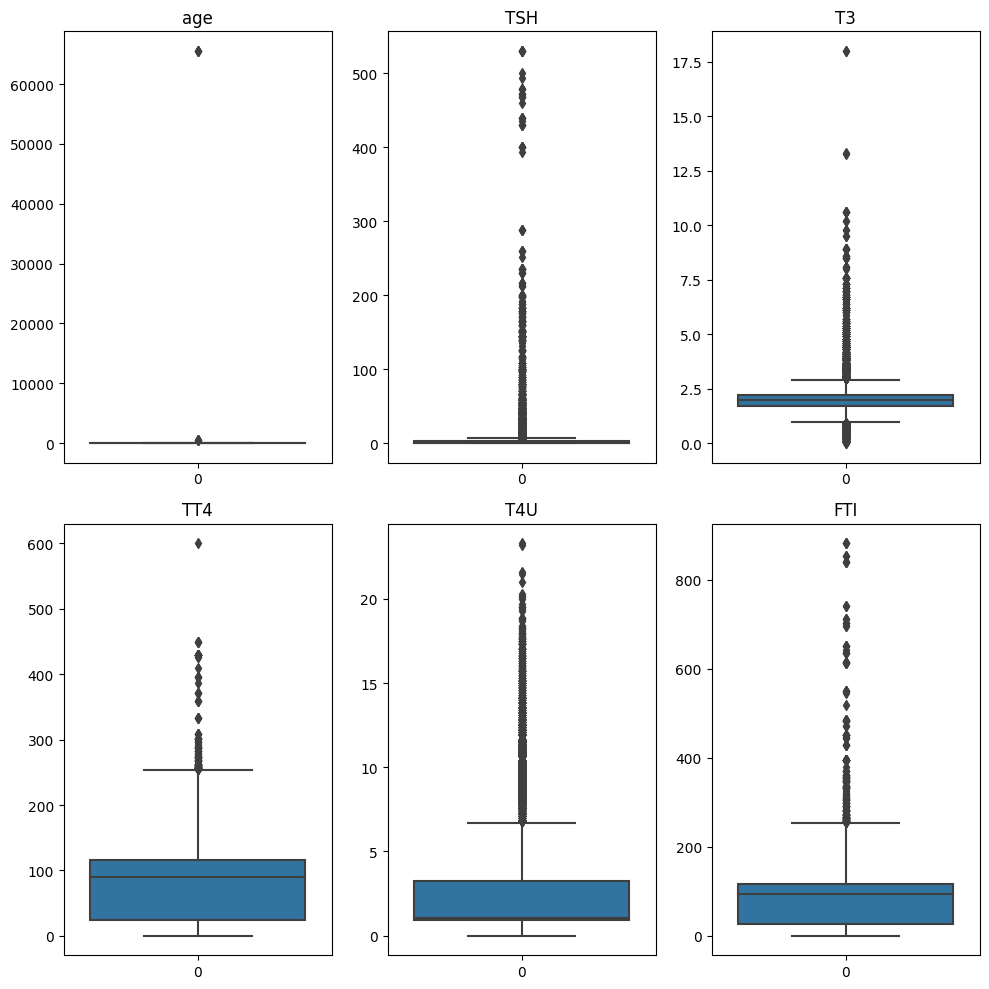

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
#Boxplot to detect outlier
numerical_col = data.select_dtypes(include=['float64'])

fig,axes=plt.subplots(2,3,figsize=(10,10))

for ax,col in zip(axes.flatten(),numerical_col.columns):
    sns.boxplot(numerical_col[col],ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

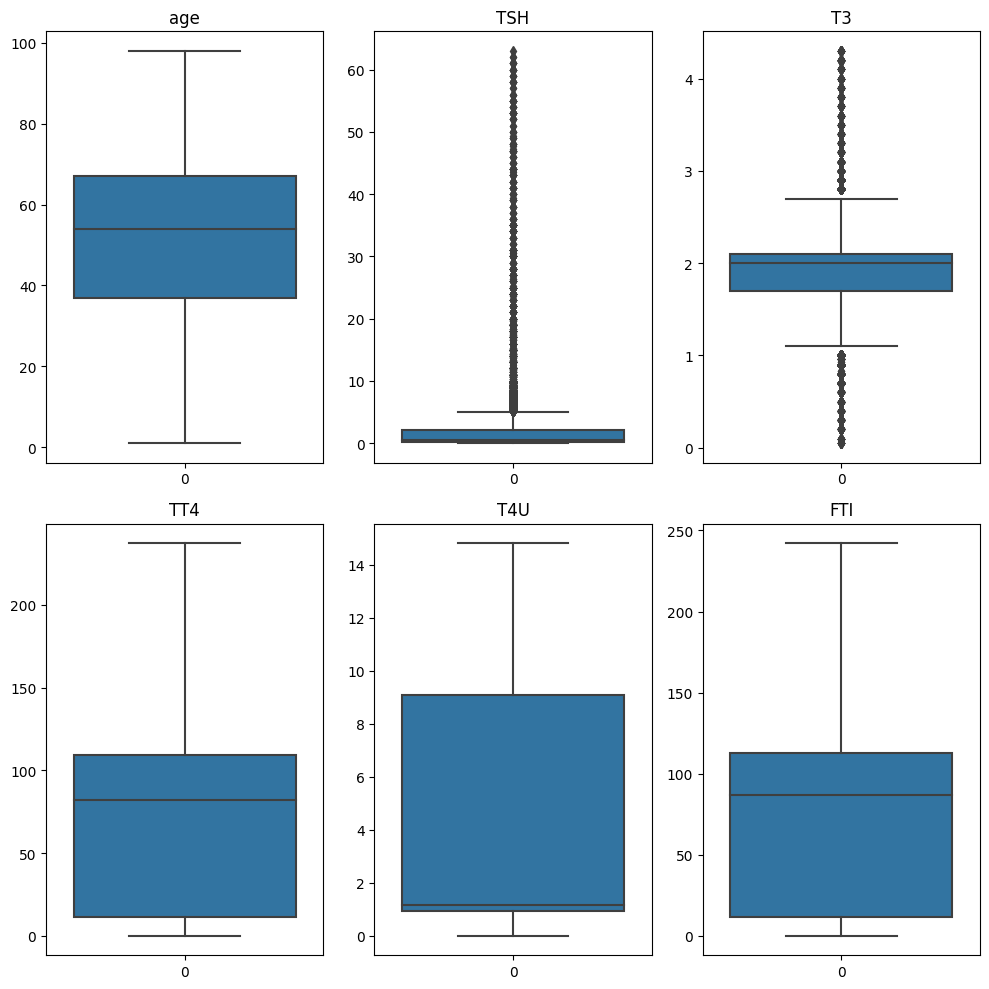

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
#Boxplot to detect outlier
numerical_col = no_outlier_data.select_dtypes(include=['float64'])

fig,axes=plt.subplots(2,3,figsize=(10,10))

for ax,col in zip(axes.flatten(),numerical_col.columns):
    sns.boxplot(numerical_col[col],ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

In [19]:
no_outlier_data.shape

(17832, 22)